# 1. 집 값 예측 모델

In [1]:
import pandas  as pd
import numpy   as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1)

#### 1) 데이터 로드

In [2]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
X_train = train.select_dtypes(include=['number']).copy()
X_train = X_train.drop(['Id', 'SalePrice'], axis=1)
y_train = train["SalePrice"]

X_test  = test.select_dtypes(include=['number']).copy()
X_test = X_test.drop(['Id'], axis=1)

X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


#### 2) 데이터 시각화

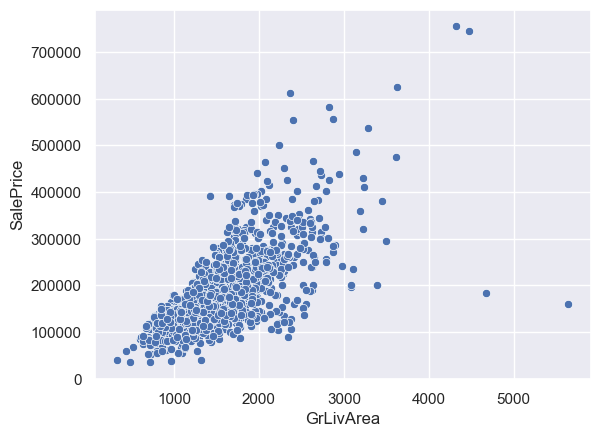

In [7]:
#lets create scatterplot of GrLivArea and SalePrice
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.show()

In [8]:
#as per above plot we can see there are two outliers which can affect on out model,lets remove those outliers
indices_to_drop = train.loc[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index
train=train.drop(indices_to_drop)
train.reset_index(drop=True, inplace=True)

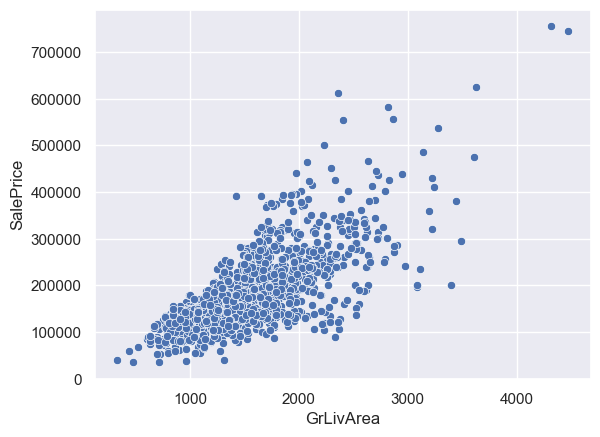

In [9]:
#lest we how its look after removing outliers
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train)
plt.show()

In [10]:
#lets create heatmap first of all lest see on which feature SalePrice is dependent
train_numeric = train.select_dtypes(include=['number']).drop(['Id'], axis=1)
corr = train_numeric.corr().sort_values(by='SalePrice', ascending=False).round(2)
print(corr['SalePrice'])


SalePrice        1.00
OverallQual      0.80
GrLivArea        0.73
TotalBsmtSF      0.65
GarageCars       0.64
1stFlrSF         0.63
GarageArea       0.63
FullBath         0.56
TotRmsAbvGrd     0.54
YearBuilt        0.52
YearRemodAdd     0.51
GarageYrBlt      0.49
MasVnrArea       0.48
Fireplaces       0.47
BsmtFinSF1       0.41
LotFrontage      0.37
WoodDeckSF       0.32
OpenPorchSF      0.32
2ndFlrSF         0.32
HalfBath         0.28
LotArea          0.27
BsmtFullBath     0.23
BsmtUnfSF        0.21
BedroomAbvGr     0.17
ScreenPorch      0.11
PoolArea         0.10
MoSold           0.05
3SsnPorch        0.04
BsmtFinSF2      -0.01
BsmtHalfBath    -0.02
MiscVal         -0.02
LowQualFinSF    -0.03
YrSold          -0.03
OverallCond     -0.08
MSSubClass      -0.08
EnclosedPorch   -0.13
KitchenAbvGr    -0.14
Name: SalePrice, dtype: float64


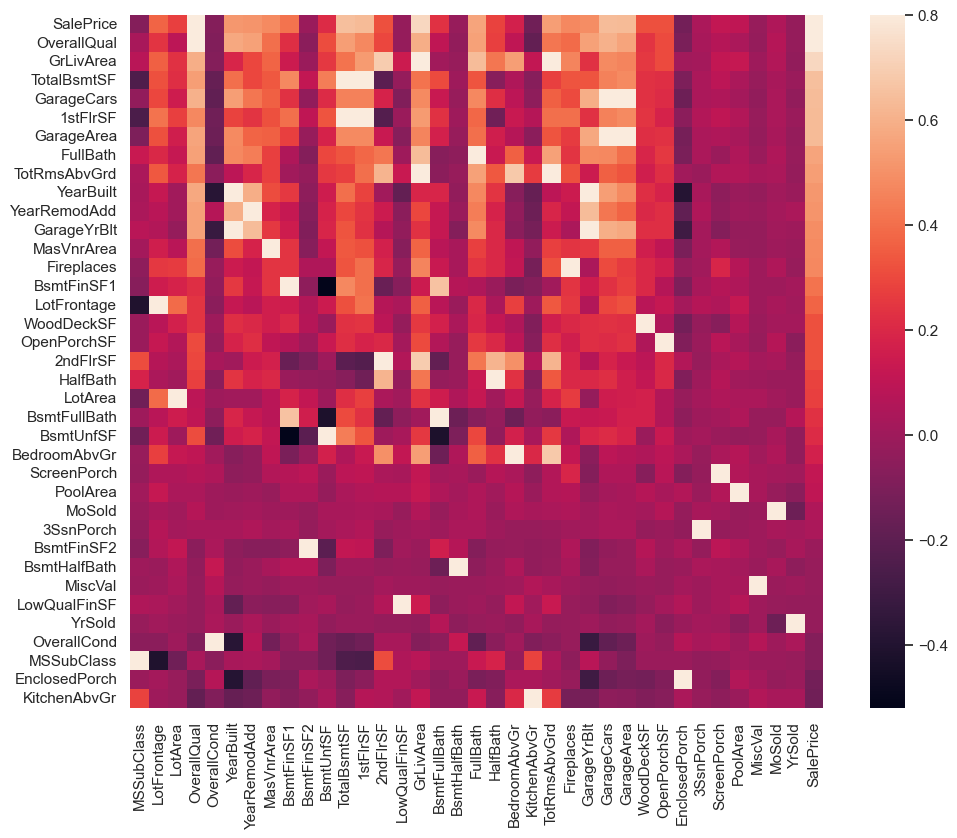

In [11]:
#here we can see SalePrice mostly dependent on this features OverallQual,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,GarageArea 
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

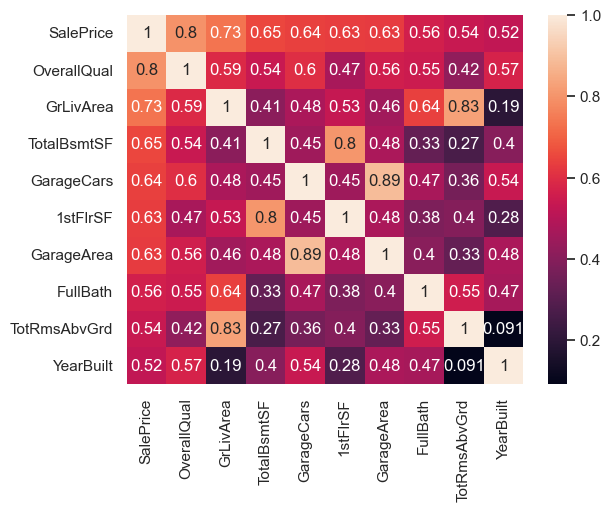

In [12]:
#now lets create heatmap for top 10 correlated features
cols =corr['SalePrice'].head(10).index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### 3) 데이터 전처리

##### - 결측값 채우기

In [13]:
#LotFrontage: all house have linear connected feet so putting most mean value
numeric_cols = X_train.columns

for col in numeric_cols:
    mean_values = train[col].dropna().mean()
    
    train[col]=train[col].fillna(mean_values) # 평균값으로 결측치 채우기
    test[col]=test[col].fillna(mean_values)

##### - Normalize: 정규화

In [14]:
X_train_before_scaled = X_train.copy()

cols = ["LotFrontage", "LotArea", "GrLivArea"]
X_train_before_scaled[cols].agg(["mean", "max", "min"])

,LotFrontage,LotArea,GrLivArea
mean,70.049958,10516.828082,1515.463699
max,313.000000,215245.000000,5642.000000
min,21.000000,1300.000000,334.000000


In [15]:
from sklearn.preprocessing import StandardScaler

#lets split data using trainrow data and scale data
transformer = StandardScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = transformer.transform(X_train[numeric_cols])
X_test[numeric_cols] = transformer.transform(X_test[numeric_cols])

In [16]:
# cols = ["LotFrontage", "LotArea", "GrLivArea"]
X_train[cols].agg(["mean", "max", "min"])

,LotFrontage,LotArea,GrLivArea
mean,-2.677107e-16,-5.840077e-17,-1.277517e-16
max,1.000839e+01,2.051827e+01,7.855574e+00
min,-2.020626e+00,-9.237292e-01,-2.249120e+00


#### 4) 모델 설정

In [18]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

In [19]:
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 600}


In [20]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.015, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
import pickle
with open("model/xgboost_feature_full.pkl", "wb") as f:
    pickle.dump(regressor, f)

In [ ]:
# with open('xgboost_feature_full.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

#### 5) Submission

In [22]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,-0.872563,0.409895,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.572835,0.053428,0.604293,...,1.202536,0.365179,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,-0.087688,-0.119110,1.64521
1,-0.872563,0.451090,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.023838,1.051363,-0.288653,...,-0.753188,2.384400,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,25.116309,-0.119110,1.64521
2,0.073375,0.162723,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.572835,0.761852,-0.288653,...,0.042202,0.939819,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.229111,1.64521
3,0.073375,0.327504,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.462340,0.347326,-0.288653,...,-0.013943,2.121024,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.119110,1.64521
4,1.492282,-1.114330,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.572835,-0.396190,-0.288653,...,0.154492,-0.752176,0.533564,-0.359325,-0.116339,2.313293,-0.068692,-0.087688,-1.969111,1.64521


In [23]:
predictions = regressor.predict(X_test)
predictions

array([127440.87, 154127.23, 190011.97, ..., 179441.08, 116117.77,
       236056.33], dtype=float32)

In [ ]:
output = pd.DataFrame({"Id": test['Id'], "SalePrice": predictions})
output.to_csv('data/submission.csv', index=False)

In [ ]:
## 여기까지 하고 Submit to competition에서 버튼 누를 것!!

# 2. Feature importance

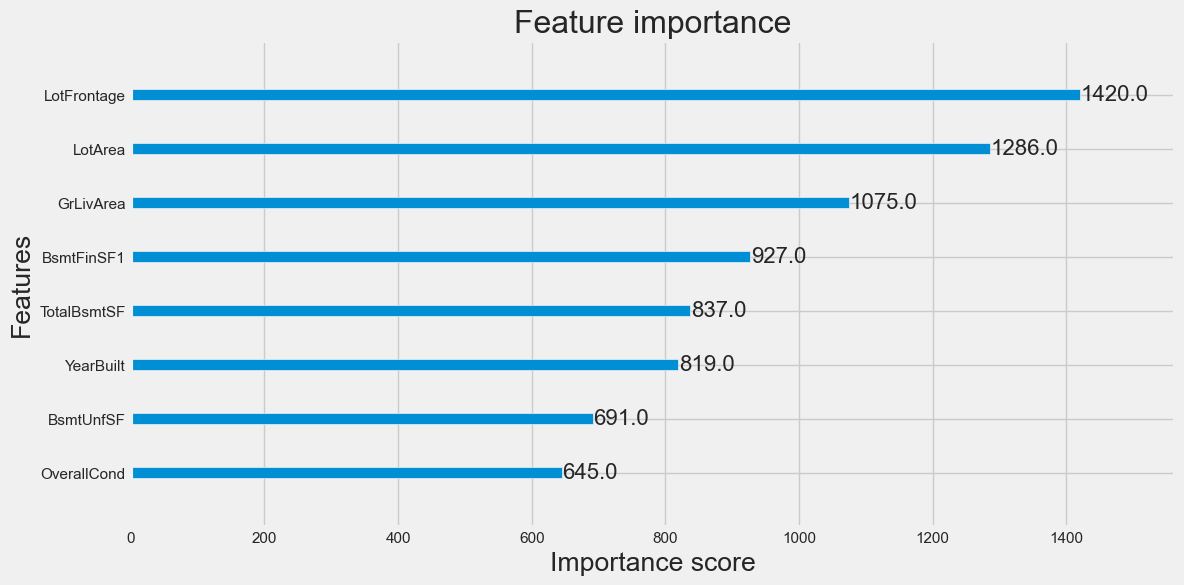

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

# 3. Simple features, unseen data

In [26]:
# Use just 3 columns => test new data by getting only 3 inputs from users

X_train = train.select_dtypes(include=['number']).copy()
X_train_ = X_train.drop(['Id', 'SalePrice'], axis=1)
y_train = train["SalePrice"]

simple_feature_cols = ["LotFrontage", "LotArea", "GrLivArea"]
X_train_simple = X_train_[simple_feature_cols]

X_train_simple.head()

,LotFrontage,LotArea,GrLivArea
0,65.0,8450,1710
1,80.0,9600,1262
2,68.0,11250,1786
3,60.0,9550,1717
4,84.0,14260,2198


In [27]:
# search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)
# regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                            n_estimators  = search.best_params_["n_estimators"],
#                            max_depth     = search.best_params_["max_depth"],
#                            eval_metric='rmsle')
model_for_simple_features = xgb.XGBRegressor()
model_for_simple_features.fit(X_train_simple, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
simple_feature_cols = ["LotFrontage", "LotArea", "GrLivArea"]
X_train_[simple_feature_cols].agg(["mean", "max", "min"])

,LotFrontage,LotArea,GrLivArea
mean,69.797331,10459.9369,1510.465706
max,313.000000,215245.0000,4476.000000
min,21.000000,1300.0000,334.000000


In [29]:
# simple_feature_cols = ["LotFrontage", "LotArea", "GrLivArea"] 
unseen_data = [
    [70, 10516, 1515], # 1번째
    [313, 215245, 5642], # 2번째
    [21, 1300, 334] # 3번째
]

In [30]:
result = model_for_simple_features.predict(unseen_data)
result

array([193058.   , 564887.75 ,  70892.336], dtype=float32)